# GLM's and Multiple Regression

In [1]:
#| code-fold: true
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import polars as pl 
import polars.selectors as cs
import preliz as pz
import pymc as pm
from scipy.interpolate import PchipInterpolator

For the most part we have really just been working in simple simple
land. We have only been passing off models that look a bit like

$$
Y = \beta_1 \times var + \varepsilon
$$

Some more astute users or just casual viewers may have noticed that we
are not specifying a model with an intercept. Which is fine for some
things probably not ideal for others! So the big thing about this
chapter for me is really just building a simple model with more moving
parts into the likelihood and then getting real funky with the
likelihood.

## OLS

In [2]:
bikes = pl.read_csv('https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/data/bikes.csv')

So the model is going to look pretty similar just with a little bit of a
remix. So $\sigma$ looks the same, for the most part, while the mu
changes a bit because you have to tell PyMC what is being multiplied to
get the mean of the whatever. So if we are specifying a model of bike
rentals with temperature as one of our predictors as in the book. The
model would look like this when we write it out mathily.

$$
\begin{aligned}
\alpha \sim Normal(0, 100) \\
\beta \sim Normal(0, 100) \\
\sigma \sim Half Cauchy(10) \\
y \sim Normal(mu, sigma)
\end{aligned}
$$

In PyMC there is one additional step to get the correct mu,

In [3]:
with pm.Model() as model_ols:
    alpha = pm.Normal('alpha', 0, 100)
    beta = pm.Normal('beta', 0, 100)
    sigma = pm.HalfCauchy('sigma', 10)
    mu = pm.Deterministic('mu', alpha + beta * bikes['temperature'].to_numpy())
    y = pm.Normal('y', mu = mu, sigma = sigma, observed=bikes['rented'].to_numpy())
    out_ols = pm.sample(nuts_sampler='nutpie')


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.70,15
,2000,0,0.78,7
,2000,0,0.72,3
,2000,0,0.76,7


### Interpreting Model output

One of the strongest points of Bayesian statistics is that we can convey
our uncertainty in way that is really plottable! However, this requires
working with the posterior. So we can extract the posterior like this.

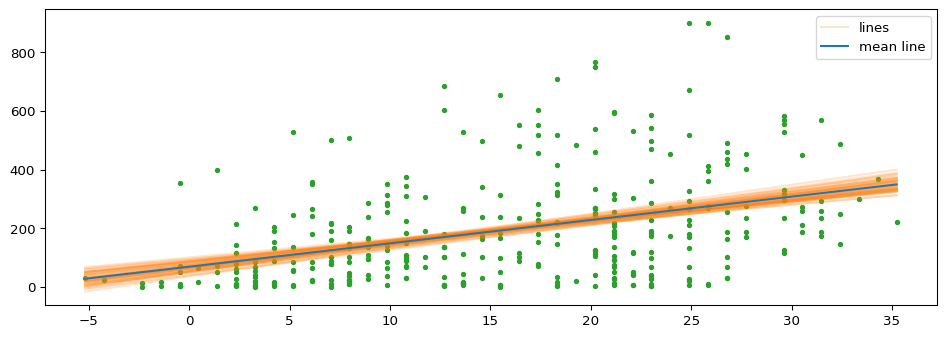

In [4]:
posterior = az.extract(out_ols, num_samples=50)

plot = xr.DataArray(
    np.linspace(bikes['temperature'].min(), bikes['temperature'].max(), 50) , dims = 'plot_id'
)

mean_lines = posterior['alpha'].mean() + posterior['beta'].mean() * plot

lines = posterior['alpha'] + posterior['beta'] * plot

hdi = az.hdi(out_ols.posterior['mu'])

fig, axes = plt.subplots(figsize = (12,4))
axes.plot(bikes['temperature'], bikes['rented'],'C2.' ,zorder=-3)
lines_ = axes.plot(plot, lines.T, c = 'C1', alpha = 0.2, label = 'lines')
axes.plot(plot, mean_lines, c = 'C0', label = 'mean line')
plt.setp(lines_[1:], label = "_")
axes.legend()


These look pretty nice! for the most part the model makes very similar
regression lines, which is generally a good sign.

### Interpreting the posterior predictions

In general when put in front of decision maker we should be able to
express what our model thinks about the future. Another important thing
is that looking at what our model thinks about the future is a pretty
good built in check. If it predicts things that cannot happen than it is
a pretty good sign that we may need to rething our model.

Sampling: [y]


Output()

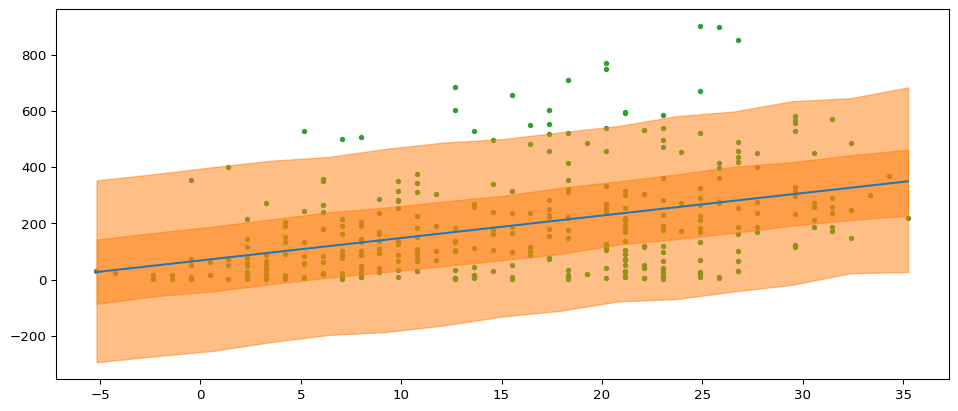

In [5]:
pm.sample_posterior_predictive(out_ols, model = model_ols, extend_inferencedata=True)

mean_line = out_ols.posterior['mu'].mean(('chain', 'draw'))

temperature = np.random.normal(bikes['temperature'], 0.01)

idx = np.argsort(temperature)

x = np.linspace(temperature.min(), temperature.max(), 15)

y_prds = out_ols.posterior_predictive['y'].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)


y_hat_bound = iter(
    [
        PchipInterpolator(temperature[idx], y_prds[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12,5))
ax.plot(bikes['temperature'], bikes['rented'], "C2.", zorder = -3)
ax.plot(bikes['temperature'][idx], mean_line[idx], c = 'C0')

for lb, ub in zip(y_hat_bound, y_hat_bound):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

## GLMS

So in the prior section we saw that we are getting negative bike
rentals. Which does not make any sense. Obviously we cannot have a
negative number for a count. So we are going to use a count model. We
could use a fish regression or a negative binomial. One really important
thing about the PyMC universe is that a bit like Stan we do have to do
some extra stuff to make sure the model knows what it is doing. So lets
go ahead and show this.

In [6]:
#| error: true
with pm.Model() as neg_model_wrong: 
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta = pm.Normal('beta', mu = 0, sigma = 10)
    sigma = pm.HalfNormal('sigma', 10)
    mu = pm.Deterministic('mu', alpha + beta * bikes['temperature'].to_numpy())
    y = pm.NegativeBinomial('y', mu = mu, alpha = alpha, observed = bikes['rented'].to_numpy())
    neg_wrong_out = pm.sample()
    neg_wrong_out.extend(pm.sample_posterior_predictive(neg_wrong_out))

neg_model_wrong.debug()

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha': array(-0.38690733), 'beta': array(-0.74528227), 'sigma_log__': array(2.16074549)}

Logp initial evaluation results:
{'alpha': np.float64(-0.99), 'beta': np.float64(-3.22), 'sigma': np.float64(-0.74), 'y': np.float64(-inf)}
You can call `model.debug()` for more details.

It looks like the model will actually get supermad and not let you do
that. Which is good lol it is probably good that there are some built in
checks with the software as well as the fact that the NUTS sampler is
probably having a hard time exploring the posterior distribution.

In [7]:
with pm.Model() as neg_model_good:
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta = pm.Normal('beta', mu = 0, sigma = 10)
    sigma = pm.HalfNormal('sigma', 10)
    mu = pm.Deterministic('mu', pm.math.exp(alpha + beta * bikes['temperature'].to_numpy()))
    y = pm.NegativeBinomial('y', mu = mu, alpha = sigma, observed = bikes['rented'].to_numpy())
    neg_good_out = pm.sample(nuts_sampler='nutpie')
    neg_good_out.extend(pm.sample_posterior_predictive(neg_good_out))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.71,3
,2000,0,0.69,7
,2000,0,0.71,3
,2000,0,0.79,7


Sampling: [y]


Output()

So when we go and look at the posterior predictive it is going to look
like

Text(0, 0.5, 'rented bikes')

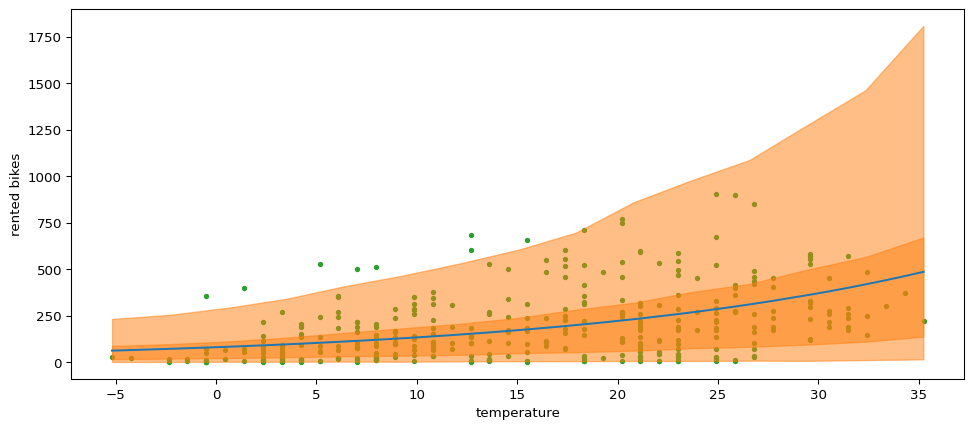

In [8]:
mean_line = neg_good_out.posterior['mu'].mean(('chain', 'draw'))
temperature = np.random.normal(bikes['temperature'].to_numpy(), 0.01)
idx = np.argsort(temperature)
x = np.linspace(temperature.min(), temperature.max(), 15)

y_pred_q = neg_good_out.posterior_predictive["y"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperature[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(bikes['temperature'], bikes['rented'], "C2.", zorder=-3)
ax.plot(bikes['temperature'][idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

### Robust regressions

One of the nice things about `PyMC` is that we can actually start doing
stuff to various parameters. So Martin uses the exmaple that he tends to
not like the plain old exponential. The reason this is because the
unshifted Exponential puts a lot of weight on values close to zero.
Which could be fine but that is probably going to be really really data
dependent. So we can do that by just passing off things to `pm.math`. So
we could theoretically shift the values our self using
`pm.math(parameter, paramater +1)`, but the problem is that once we pass
this to the likelihood it is not going to sample the way we want it to.

In [9]:
ans = pl.read_csv('https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/data/anscombe_3.csv')

with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu = ans['y'].mean(), sigma = 1)
    beta = pm.Normal('beta', mu = 0, sigma = 1)
    sigma = pm.HalfNormal('sigma', 5)
    nu = pm.Exponential('nu', 1/29) 
    nu_shifted = pm.Deterministic('nu_shift', nu + 1)
    mu = pm.Deterministic('mu', alpha + beta * ans['x'].to_numpy())
    y = pm.StudentT('y', mu = mu, sigma = sigma, nu = nu, observed=ans['y'].to_numpy())
    out_model_t = pm.sample(2000, nuts_sampler='nutpie')


Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.60,7
,3000,0,0.80,7
,3000,0,0.72,7
,3000,0,0.57,3


So if we look at her compared to the non-robust version

/Users/josh/Library/CloudStorage/Dropbox/learning-bayes/bayesian-analysis-with-python/.venv/lib/python3.13/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


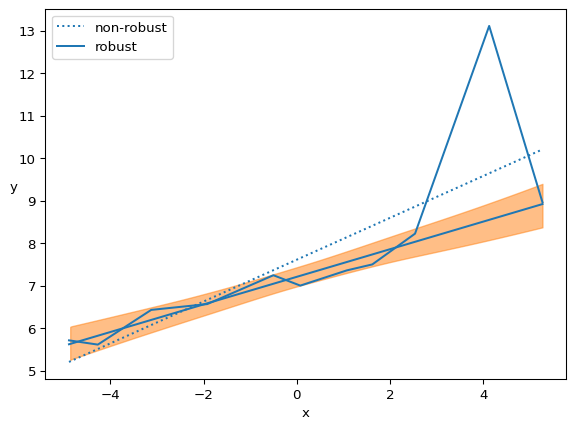

In [10]:
from scipy.stats import linregress

beta_c, alpha_c, *_ = linregress(ans['x'], ans['y'])

_, ax = plt.subplots()
ax.plot(ans['x'], (alpha_c + beta_c * ans['x']), "C0:", label="non-robust")
ax.plot(ans['x'], ans['y'], "C0")
alpha_m = out_model_t.posterior["alpha"].mean(("chain", "draw"))
beta_m = out_model_t.posterior["beta"].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(ans['x'].min(), ans['x'].max(), 50), dims="plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c="C0", label="robust")
az.plot_hdi(ans['x'], az.hdi(out_model_t.posterior["mu"])["mu"].T, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.legend(loc=2)

### Logits

A Bayesian classifier. So lets see the centering and scaling in action

In [11]:
iris = pl.read_csv('https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/data/iris.csv').filter(pl.col('sepal_length').is_not_nan())

cleanish = iris.filter(pl.col('species').is_in(['setosa', 'versicolor'])).with_columns(
    (pl.col('sepal_length')-pl.col('sepal_length').mean()).alias('centered'),
)

y_0 = cleanish['species'].cast(pl.Categorical).to_physical().to_numpy()

x_n = cleanish['sepal_length']

x_c = cleanish['centered'].to_numpy()

x_0 = cleanish['sepal_length']

with pm.Model() as logit:
    alpha = pm.Normal('alpha', mu = 0, sigma= 1)
    beta = pm.Normal('beta', mu = 0, sigma = 5)
    mu = alpha + x_c * beta
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha/beta)
    yl = pm.Bernoulli('y', p = theta, observed = y_0)
    out_logit = pm.sample(nuts_sampler='nutpie')

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,1.04,3
,2000,0,1.10,3
,2000,0,1.09,3
,2000,0,1.06,3


Now lets see how well this matches the book

/Users/josh/Library/CloudStorage/Dropbox/learning-bayes/bayesian-analysis-with-python/.venv/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/josh/Library/CloudStorage/Dropbox/learning-bayes/bayesian-analysis-with-python/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


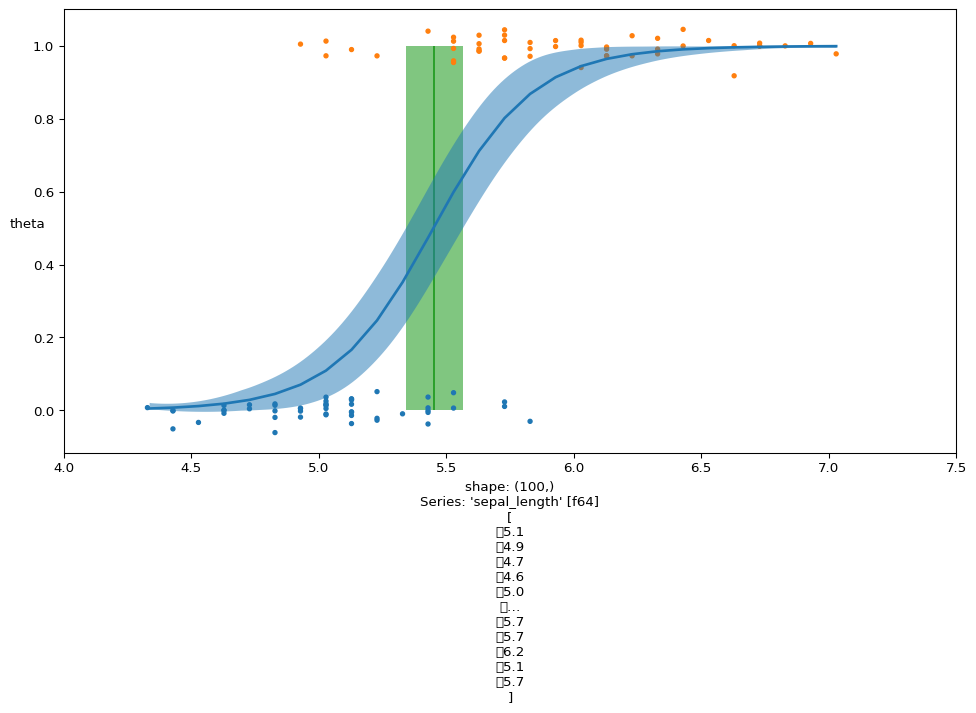

In [12]:
posterior = out_logit.posterior
theta = posterior["theta"].mean(("chain", "draw"))
idx = np.argsort(x_c)

_, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_c[idx], theta[idx], color="C0", lw=2)
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])
az.plot_hdi(x_c, posterior["theta"], color="C0", ax=ax, fill_kwargs={"lw": 0})
ax.set_xlabel(x_n)
ax.set_ylabel("theta", rotation=0)
# # use original scale for xticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1))

## Variable variance

What happens when we are presented with a good old fashion problem of
what happens when we violate one of our many assumptions of OLS how do
we fix that? Well in some respects the most straightforward answer is to
change how we specify the model. Whether this is moving from a static
regression to a time-series model or incorporating group structures.
Sometimes making a more complex model is not neccessarily worth it when
we can just fix it with a transformation or robust standard errors. If
we examine the data from the WHO.

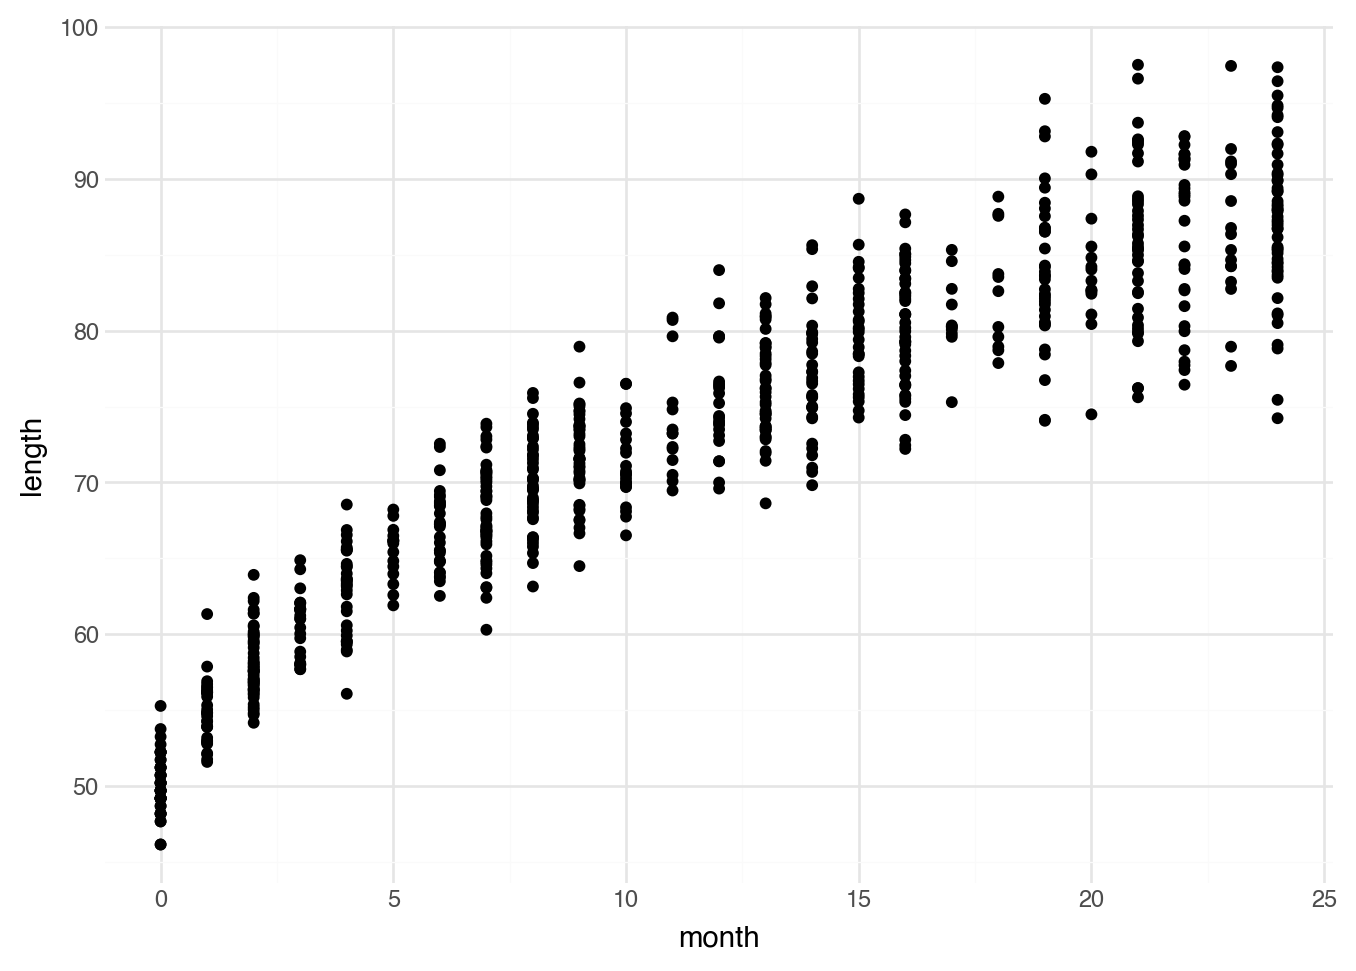

In [13]:
import plotnine as pn 

babies_who = pl.read_csv('https://raw.githubusercontent.com/aloctavodia/BAP3/refs/heads/main/code/data/babies.csv')


bb_plt = (pn.ggplot(babies_who, pn.aes(x = 'month', y = 'length')) +
       pn.geom_point() +
       pn.theme_minimal())

bb_plt

I think for the most part we would be comfortable just fitting a
polynomial and calling it a day. In R or in bambi this is a fairly easy
process. In PyMC, to be fair, this is also easy but it looks a bit
different. So the thing is that in the book they have `pm.MutableData`
which because Python is a bit more aggressive with how things get
deprecated no longer works. In part one of the good things is that now
all data containers are mutable so there is now no need to have a
specialized container.

In [14]:
with pm.Model(
    #coords = {'obs_idx':np.arange(len(babies_who)), "parameter": ['intercept', 'slope']}
    ) as model_babies:
        x_shared = pm.Data("x_shared", babies_who['month'].cast(pl.Float64).to_numpy())
        alpha = pm.Normal('alpha', sigma = 10)
        beta = pm.Normal('beta', sigma = 10)
        gamma = pm.HalfNormal('gamma', sigma = 10)
        delta = pm.HalfNormal('delta', sigma = 10)
        mu = pm.Deterministic('mu', alpha + beta * x_shared**0.5)
        sigma = pm.Deterministic('sigma', gamma + delta * x_shared)
        y = pm.Normal('y', mu = mu, sigma = sigma, observed = babies_who['length'].to_numpy())
        out_babies = pm.sample(nuts_sampler='nutpie')


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.68,3
,2000,0,0.67,7
,2000,0,0.66,7
,2000,0,0.67,3


Okay now lets see how good this worked. For the most part this looks
more or less like the

Text(0, 0.5, '$\\bar \\sigma$')

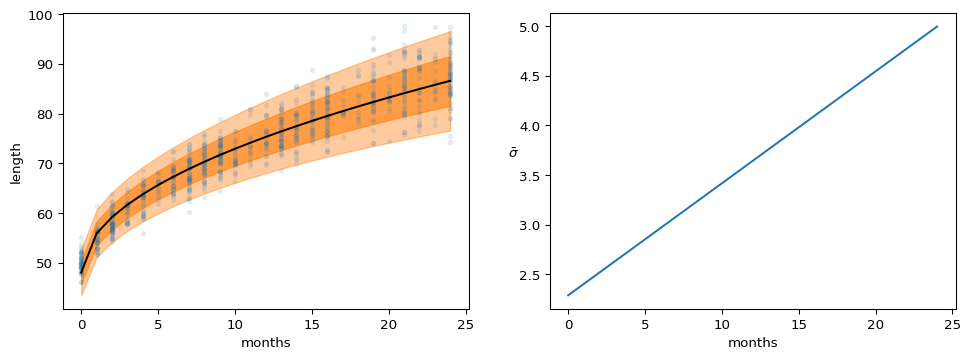

In [15]:
_, axes = plt.subplots(1,2, figsize = (12,4))
axes[0].plot(babies_who['month'], babies_who['length'], 'C0.', alpha = 0.1)
posterior = az.extract(out_babies)
mu_m = posterior['mu'].mean('sample').values
sigma_m = posterior['sigma'].mean('sample').values

axes[0].plot(babies_who['month'], mu_m, c = 'k')
axes[0].fill_between(babies_who['month'], mu_m + 1 * sigma_m, mu_m - 1 * sigma_m, alpha=0.6, color="C1")
axes[0].fill_between(babies_who['month'], mu_m + 2 * sigma_m, mu_m - 2 * sigma_m, alpha=0.4, color="C1")

axes[0].set_xlabel('months')
axes[0].set_ylabel('length')

axes[1].plot(babies_who['month'], sigma_m)
axes[1].set_xlabel("months")
axes[1].set_ylabel(r"$\bar \sigma$", rotation=0)

## HMLM

We did some of the bare bones of builiding MLM's in the prior chapter but in practice they are a bit more complicated than what we were
dealing with in the prior